In [133]:
from dataclasses import dataclass
from enum import Enum
import random

import numpy as np
import torch
import matplotlib.pyplot as plt

from c_tictactoe_py import TicTacToeEnvPy, Settings

In [134]:
def soft_update(from_net, to_net, tau = 0.005) -> None:
    to_s_dict = to_net.state_dict()
    from_s_dict = from_net.state_dict()
    for key in from_s_dict:
        to_s_dict[key] = from_s_dict[key] * tau + to_s_dict[key] * (1 - tau)

    to_net.load_state_dict(to_s_dict)

In [135]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = torch.nn.Linear(18, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 9)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [136]:
@dataclass
class Params:
    lr: float
    gamma: float
    batch_size: int
    buffer_size: int
    n_envs: int
    num_steps: int
    # num_episodes: int
    num_eval_steps: int
    device: str
    num_opt_steps: int
    tau: float
    warmup: int

@dataclass
class Batch:
    states: np.ndarray
    actions: np.ndarray
    rewards: np.ndarray
    next_states: np.ndarray
    dones: np.ndarray

class Buffer:
    def __init__(self, buffer_size: int, n_envs: int):
        self.buffer_idx = 0
        self.buffer_size = buffer_size
        self.full = False
        self.n_envs = n_envs
        self.state_buffer = np.zeros((self.buffer_size, self.n_envs, 18), dtype=np.int16)
        self.reward_buffer = np.zeros((self.buffer_size, self.n_envs), dtype=np.int16)
        self.done_buffer = np.zeros((self.buffer_size, self.n_envs), dtype=np.int16)
        self.action_buffer = np.zeros((self.buffer_size, self.n_envs), dtype=np.int16)

    def store(self, state, action, reward, done):
        self.state_buffer[self.buffer_idx] = state
        self.action_buffer[self.buffer_idx] = action
        self.reward_buffer[self.buffer_idx] = reward
        self.done_buffer[self.buffer_idx] = done
        self.buffer_idx += 1
        if self.buffer_idx >= self.buffer_size:
            self.buffer_idx = 0
            self.full = True

    def sample(self, batch_size) -> Batch:
        """SARS'D"""
        # No check for filled buffer in here.
        indices = np.random.randint(0, self.buffer_size - 1 if self.full else self.buffer_idx - 1, batch_size)
        next_indices = indices
        # SARSD
        return Batch(
            self.state_buffer[indices],
            self.action_buffer[indices],
            self.reward_buffer[indices],
            self.state_buffer[next_indices],
            self.done_buffer[indices]
        )

In [137]:
class ActionType(Enum):
    ARGMAX = 0
    EPSILON_GREEDY = 1
    STOCHASTIC = 2

def get_action(model: MLP, input: torch.Tensor, action_type: ActionType) -> np.ndarray:
    # argmax
    match action_type:
        case ActionType.ARGMAX:
            with torch.no_grad():
                return model(input).argmax().numpy(force=True).astype(np.int16)
        case ActionType.EPSILON_GREEDY:
            if random.random() < 0.25:
                return np.random.randint(0, 8, size=input.shape[0]).astype(np.int16)
            with torch.no_grad():
                return model(input).max(1).values.flatten().numpy(force=True).astype(np.int16)
        # case ActionType.STOCHASTIC:
            # with torch.no_grad():
                # return torch.distributions.Categorical(logits=model(input)).sample().item()
                # return torch.multinomial(torch.softmax(action, 1), 1).flatten().numpy(force=True)

In [138]:
def optimize_model(policy: MLP, target: MLP, optimizer: torch.optim.Optimizer, buffer: Buffer, params: Params):
    if buffer.buffer_idx < params.batch_size and not buffer.full:
        return 0
    batch = buffer.sample(params.batch_size)
    policy.train()

    state_tensor = torch.tensor(batch.states).to(device=params.device, non_blocking=True).reshape(-1, 18)
    action_tensor = torch.tensor(batch.actions).to(device=params.device, non_blocking=True).reshape(-1, 1)
    reward_tensor = torch.tensor(batch.rewards).to(device=params.device, non_blocking=True).reshape(-1, 1)
    next_state_tensor = torch.tensor(batch.next_states).to(device=params.device, non_blocking=True).reshape(-1, 18)
    done_tensor = torch.tensor(batch.dones).to(device=params.device, non_blocking=True).reshape(-1, 1)

    state_action_values = policy(state_tensor.to(torch.float32))
    state_action_values = state_action_values.gather(1, action_tensor.to(torch.int64))

    next_state_values = torch.zeros(params.batch_size, device=params.device)
    with torch.no_grad():
        next_state_values = target(next_state_tensor.to(torch.float32))
        next_state_values = next_state_values.max(1).values.reshape(-1, 1)
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * (1 - done_tensor) * params.gamma) + reward_tensor

    # Compute Huber loss
    criterion = torch.nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values)

    # Optimize the policy
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy.parameters(), 100)
    optimizer.step()
    return loss.detach().cpu().numpy()

In [139]:
def eval(model: MLP, env: TicTacToeEnvPy, params: Params):
    model.eval()
    rewards = np.zeros((params.n_envs, params.num_eval_steps))
    with torch.no_grad():
        states, infos = env.reset_all()
        for i in range(params.num_eval_steps):
            state_tensor = torch.tensor(states, device=params.device, dtype=torch.float32)
            actions = get_action(model, state_tensor, ActionType.EPSILON_GREEDY)
            state, reward, done, _ = env.step(actions)
            # print(state, actions, reward, done)
            rewards[:, i] = reward
            # print(reward)
        r = np.mean(rewards)
        return r

[array(0.35153666, dtype=float32), array(0.29689476, dtype=float32), array(0.25056776, dtype=float32), array(0.22923975, dtype=float32), array(0.21018524, dtype=float32), array(0.18996814, dtype=float32), array(0.1857177, dtype=float32), array(0.1764888, dtype=float32), array(0.15974817, dtype=float32), array(0.14675051, dtype=float32), array(0.14737655, dtype=float32), array(0.14326407, dtype=float32), array(0.12920977, dtype=float32), array(0.11983507, dtype=float32), array(0.12515748, dtype=float32), array(0.10372651, dtype=float32), array(0.10155102, dtype=float32), array(0.10038925, dtype=float32), array(0.08839481, dtype=float32), array(0.08154121, dtype=float32), array(0.07601113, dtype=float32), array(0.06925982, dtype=float32), array(0.07220516, dtype=float32), array(0.0507153, dtype=float32), array(0.05508616, dtype=float32), array(0.04727963, dtype=float32), array(0.04880627, dtype=float32), array(0.04084852, dtype=float32), array(0.03857255, dtype=float32), array(0.04448931

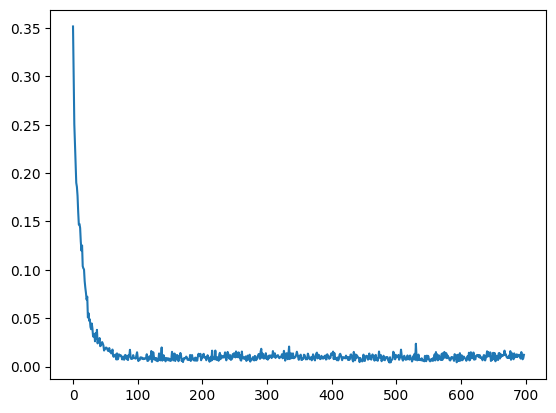

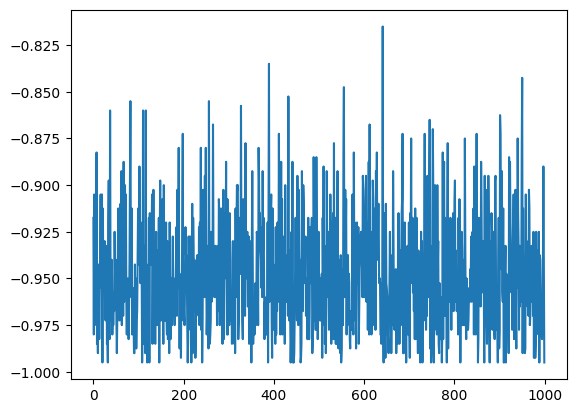

In [140]:
params = Params(
    lr=1e-3,
    gamma=0.99,
    batch_size=256,
    buffer_size=25_000,
    n_envs=2,
    # num_episodes=1000,
    num_eval_steps=200,
    device="cpu",
    num_steps=100_000,
    num_opt_steps=2,
    tau=0.05,
    warmup=10_000,
)
vec_env = TicTacToeEnvPy(Settings(batch_size=params.n_envs))
vec_env.reset_all()
policy = MLP().to(params.device)
target = MLP().to(params.device)
buffer = Buffer(params.buffer_size, params.n_envs)
optimizer = torch.optim.AdamW(policy.parameters(), lr=params.lr, amsgrad=True)
steps_done = 0
losses = []
evals = []

for step in range(params.num_steps):
    # Initialize the environment and get its state
    state = torch.tensor(vec_env.game_states, dtype=torch.float32, device=params.device)
    actions = get_action(policy, state, ActionType.EPSILON_GREEDY)
    observations, rewards, dones, _ = vec_env.step(actions)

    # Store the transition in memory
    buffer.store(observations, actions, rewards, dones)

    if step % 100 == 0:
        evals.append(eval(policy, vec_env, params))

    if step < params.warmup:
        continue

    # Perform one step of the optimization (on the policy network)
    if (step + 1) % (params.batch_size + 2) == 0:
        for _ in range(params.num_opt_steps):
            loss = optimize_model(policy, target, optimizer, buffer, params)
            losses.append(loss)

            soft_update(target, policy, tau=params.tau)

print(losses)
plt.plot(losses)
plt.show()
plt.plot(evals)
plt.show()

In [141]:
policy(torch.zeros(1, 18))

tensor([[-0.3001, -0.1512, -0.1669, -0.3004, -0.1925, -0.1460, -0.1333, -0.2219,
         -0.0591]], grad_fn=<AddmmBackward0>)